In [1]:
from hypernetworks.core.Hypernetwork import Hypernetwork
from hypernetworks.utils.HTCompiler import load_parser, compile_hn
from IPython.display import Image, display
import graphviz
import os
from plantuml import PlantUML

pictures_dir = "pictures/C4/"
parser = load_parser()

In [2]:
lookup={
    "customer":               {"C": "context", "title": "Personal Banking Customer", "stereotype": "Person", "description": "A customer of the bank, with personal bank accounts."},
    "ibs":                    {"C": "context", "title": "Internet Banking System", "stereotype": "Software System", "description": "Allows customers to view information about their bank accounts, and make payments."},
    "mainframe":              {"C": "context", "title": "Mainframe Banking System", "stereotype": "Software System", "description": "Stores all of the core banking infrormation about customers, accounts, transaction etc."},
    "email":                  {"C": "context", "title": "E-mail System", "stereotype": "Software System", "description": "The internal Microsoft Exchange e-mail system."},
   
    "view-account-agg":           {"label": "Views account balances, and makes payments using"},
    "view-account-mainframe-agg": {"label": "Gets account information from, and makes payments using"},
    "send-email-cust-agg":        {"label": "Sends e-mail to"},
    "send-ibs-email-agg":         {"label": "Sends e-mail using"},
    
    "web-app":                {"C": "container", "title": "Web Application", "stereotype": "Container: Java and Sprint MVC", "description": "Delivers and static content and the Internet banking single page appliation."},
    "spa":                    {"C": "container", "title": "Single-Page Application", "stereotype": "Container: JavaScript and Angular", "description": "Provides all of the Internet banking functionality to customers via their web browser."},
    "database":               {"C": "container", "title": "Database", "stereotype": "Container: Oracle Database Schema", "description": "Stores user registration information, hashed authentication credentials, access logs etc."},
    "mob-app":                {"C": "container", "title": "Mobile App", "stereotype": "Container: Xamarin", "description": "Provides a limited subset of the Internet banking functionality to customers via their mobile device."},
    "api":                    {"C": "container", "title": "API Application", "stereotype": "Container: Java and Spring MVC", "description": "Provides Internet banking functionality via a JSON/HTTPS API."},
    
    "visit-bank":             {"label": "Visits bigbank.com/ib using", "stereotype": "HTTPS"},
    "view-account-spa":       {"label": "Views account balances, and makes payments", "stereotype": ""},
    "view-account-mob-app":   {"label": "Views account balances, and makes payments", "stereotype": ""},
    "deliver-to-spa":         {"label": "Delivers to the customer's web browser", "stereotype": ""},
    "make-spa-api-call":      {"label": "Make API call to", "stereotype": "JSON/HTTPS"},
    "make-mob-app-api-call":  {"label": "Make API call to", "stereotype": "JSON/HTTPS"},
    "read-db":                {"label": "Reads from and writes to", "stereotype": "JDBC"},
    "send-email":             {"label": "Sends e-mail using", "stereotype": "SMTP"},
    "send-email-cust":        {"label": "Sends e-mail to", "stereotype": ""},
    "call-mainframe":         {"label": "Makes API calls to", "stereotype": "XML/HTPTS"},
    "visit-bank-ret":         {"label": "Redirect to SPA", "stereotype": "HTTPS"}
}

In [3]:
ibs_container = Hypernetwork()

compile_hn(ibs_container, parser, """
    ibs=<web-app, mob-app, spa, api, database; R_container>[N2]
    
    send-ibs-email-agg =         {send-email; R_agg_flows}[N2]
    view-account-agg =           {visit-bank, view-account-spa, view-account-mob-app; R_agg_flows}[N2]
    view-account-mainframe-agg = {call-mainframe; R_agg_flows}[N2]
    send-email-cust-agg =        {send-email-cust; R_agg_flows}[N2]
    
    visit-bank =             <customer, web-app; R_flow>[N1]
    view-account-spa =       <customer, spa; R_flow>[N1]
    view-account-mob-app =   <customer, mob-app; R_flow>[N1]
    deliver-to-spa =         <web-app, spa; R_flow>[N1]
    make-spa-api-call =      <spa, api; R_flow>[N1]
    make-mob-app-api-call =  <mob-app, api; R_flow>[N1]
    read-db =                <api, database; R_flow>[N1]
    send-email =             <api, email; R_flow>[N1]
    send-email-cust =        <email, customer; R_flow>[N2]
    call-mainframe =         <api, mainframe; R_flow>[N1]
""")

ibs_api_component = Hypernetwork()

compile_hn(ibs_api_component, parser, """
    flow=<visit-bank, visit-bank-ret, view-account-spa, make-spa-api-call, read-db, read-db-ret, make-spa-api-call-ret, view-account-spa-ret; R_sequence>
    visit-bank-ret=<web-app, customer; R_return>
    view-account-spa-ret=<spa, customer; R_return>
    make-spa-api-call-ret=<api, spa; R_return>
    read-db-ret=<database, api; R_return>
""")

In [4]:
def gen_sequence(hn, seq, lookup):
    res_start = "@startuml"
    res_end = "@enduml"
    
    res = res_start + "\n"
    
    sequence = hn.hypernetwork[seq]

    for v in sequence.simplex:
        hs = hn.hypernetwork[v]
        frm = hs.simplex[0].replace(" ", "_").replace("-", "_")
        to = hs.simplex[1].replace(" ", "_").replace("-", "_")
        lbl = hs.vertex
        arrow = ""

        if hs.R.name == "flow":
            arrow = " -> "
            
        if hs.R.name == "return":
            arrow = " --> "
            
        res += frm + arrow + to + ": " + lbl + "\n"

    res += res_end
    
    return res

@startuml
customer -> web_app: visit-bank
web_app --> customer: visit-bank-ret
customer -> spa: view-account-spa
spa -> api: make-spa-api-call
api -> database: read-db
database --> api: read-db-ret
api --> spa: make-spa-api-call-ret
spa --> customer: view-account-spa-ret
@enduml


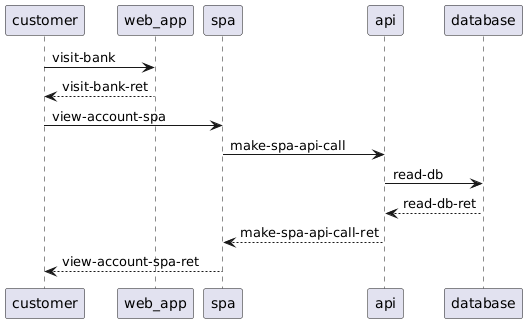

In [5]:
ibs_seq = Hypernetwork()

ibs_seq.merge(ibs_container)
ibs_seq.merge(ibs_api_component)

with open(pictures_dir+"diagram.puml", "w") as file:
    file.write(gen_sequence(ibs_seq, "flow", lookup))

plantuml = PlantUML(url="http://www.plantuml.com/plantuml/img/")
plantuml.processes_file(pictures_dir+"diagram.puml")

print(gen_sequence(ibs_seq, "flow", lookup))
Image(filename=pictures_dir+"diagram.png")